In [182]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [183]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from utils import *

In [184]:
data_dir = "~/Desktop/aiffel/AIFFEL_quest_rs/Exploration/Ex02/data"

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')

## 1. 데이터 살펴보기

In [185]:
# load dataset
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print('train data dim : {}'.format(train.shape))
print('sub data dim : {}'.format(test.shape))   # test data는 price가 없다.

train data dim : (15035, 21)
sub data dim : (6468, 20)


#### dataset features

```plaintext
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 근처 15 가구의 주거 공간, 평방 피트
21. sqft_lot15 : 근처 15가구의 부지, 평방 피트
```

In [186]:
# check train set
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [187]:
# initialize y as price column and delete price column from train set
y = train['price']
del train['price']

print(train.columns)
print(test.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


## 2. 간단한 전처리 

### id, date 변수 정리
id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다.<br>
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만들겠습니다.

In [188]:
# delete id column
test_id = test['id']

del train['id']
del test['id']

In [189]:
# remove values of date column except for year and month
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

# split date column into year and month
train['year'] = train['date'].astype(str).str[:4].astype(int)  # 앞의 4자리 (연도)
train['month'] = train['date'].astype(str).str[4:].astype(int) # 뒤의 2자리 (월)

test['year'] = test['date'].astype(str).str[:4].astype(int)  # 앞의 4자리 (연도)
test['month'] = test['date'].astype(str).str[4:].astype(int) # 뒤의 2자리 (월)

# move year and month column to the front
cols = ['year', 'month'] + [col for col in train.columns if col not in ['year', 'month']]
train = train[cols]
test = test[cols]

# delete date column
del train['date']
del test['date']

# check train set
train.head()

,year,month,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2014,10,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,2015,2,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2015,2,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,2014,6,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,2015,1,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### feature engineering
1. 한 쪽으로 쏠린 분포를 가진 경우 log-scaling
2. 집이 거래일 기준으로 몇년 전에 지어졌는지(age)에 대한 feature 추가
3. 집 위치 관련 특성 preprocessing

#### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

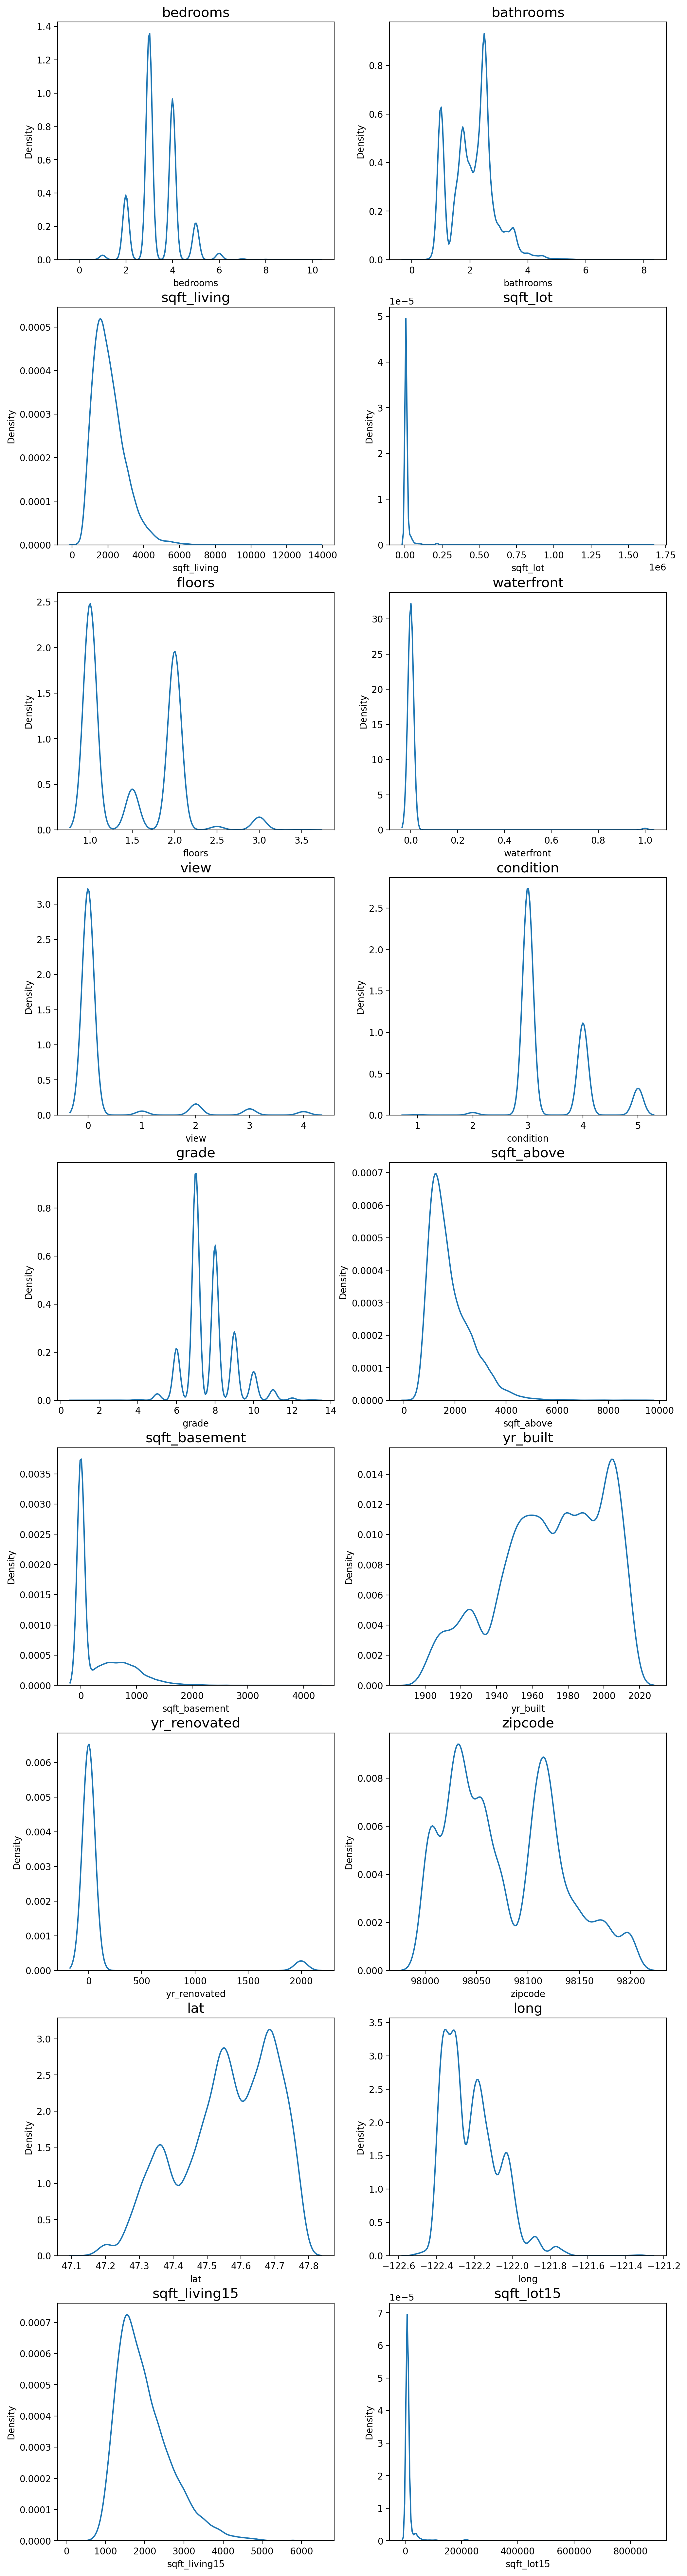

In [190]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))

# date 변수는 제외하고 분포를 확인합니다.
count = 2
columns = train.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 20 :
            break

'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15' 변수가 한쪽으로 치우친 경향을 보였습니다.<br>

__log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.__

In [191]:
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)

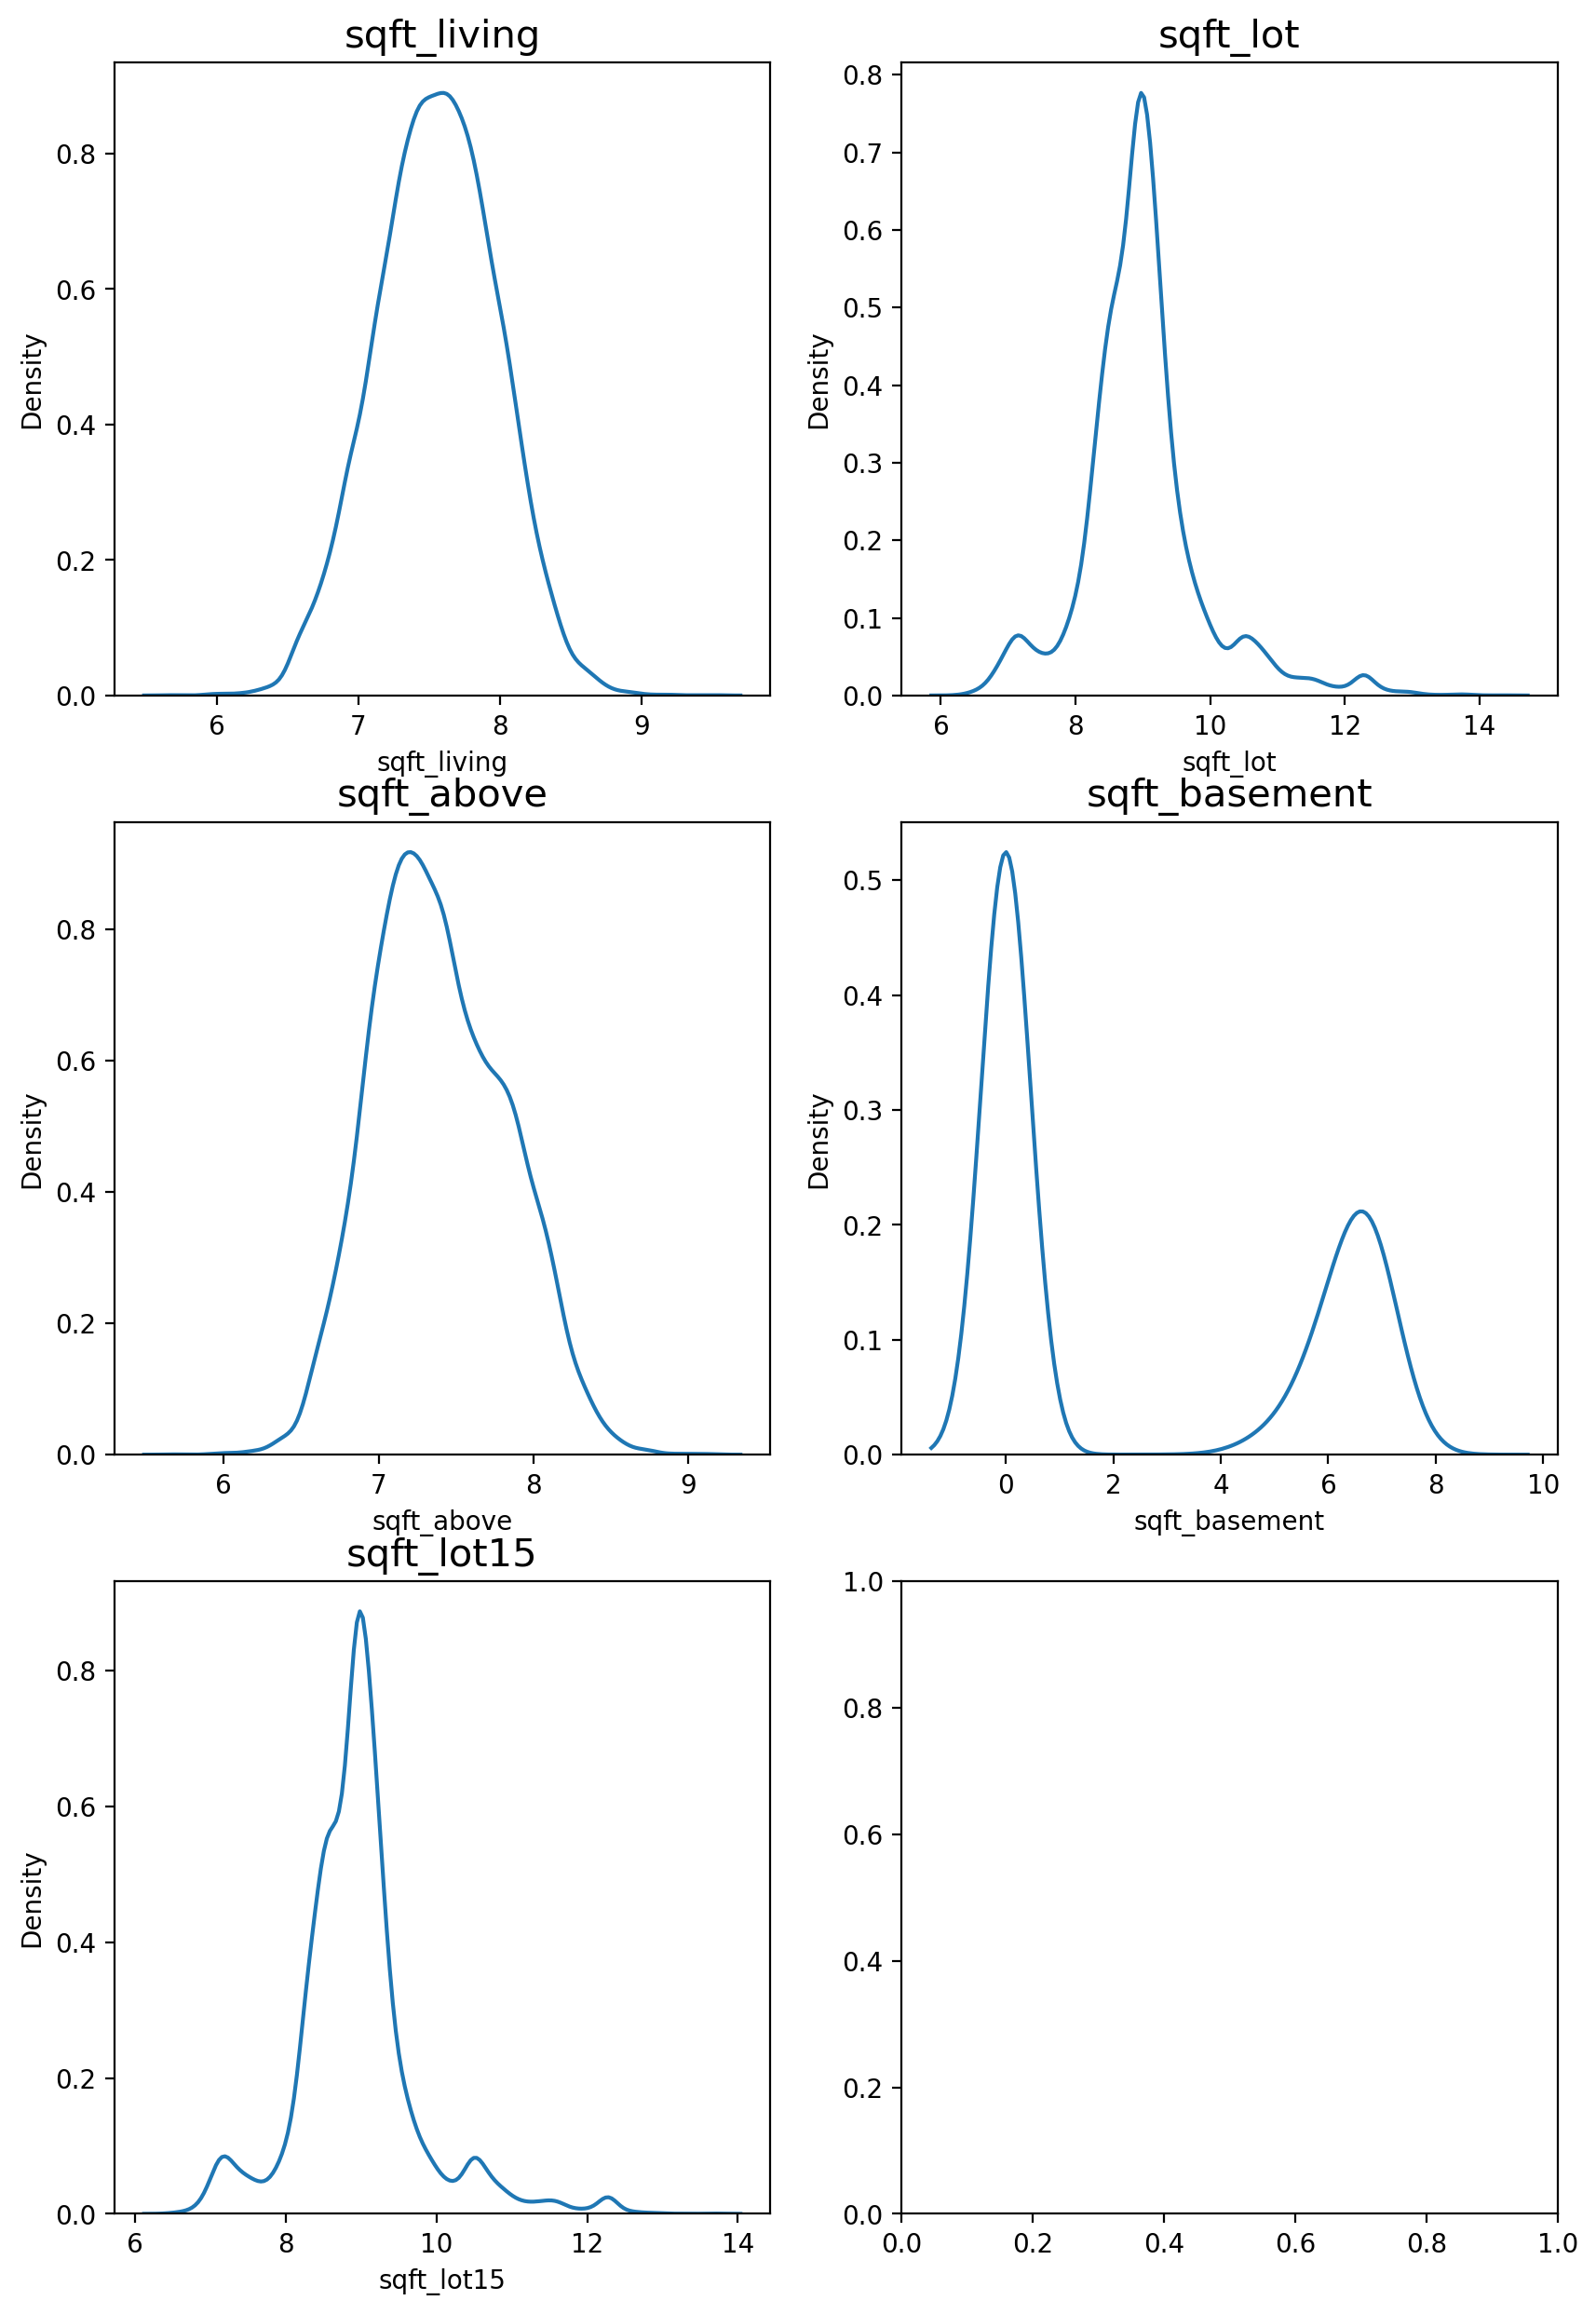

In [192]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(train[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1

In [193]:
# test set에도 동일하게 적용
for c in skew_columns:
    test[c] = np.log1p(test[c].values)

라벨 y에 대해서도 log-scaling

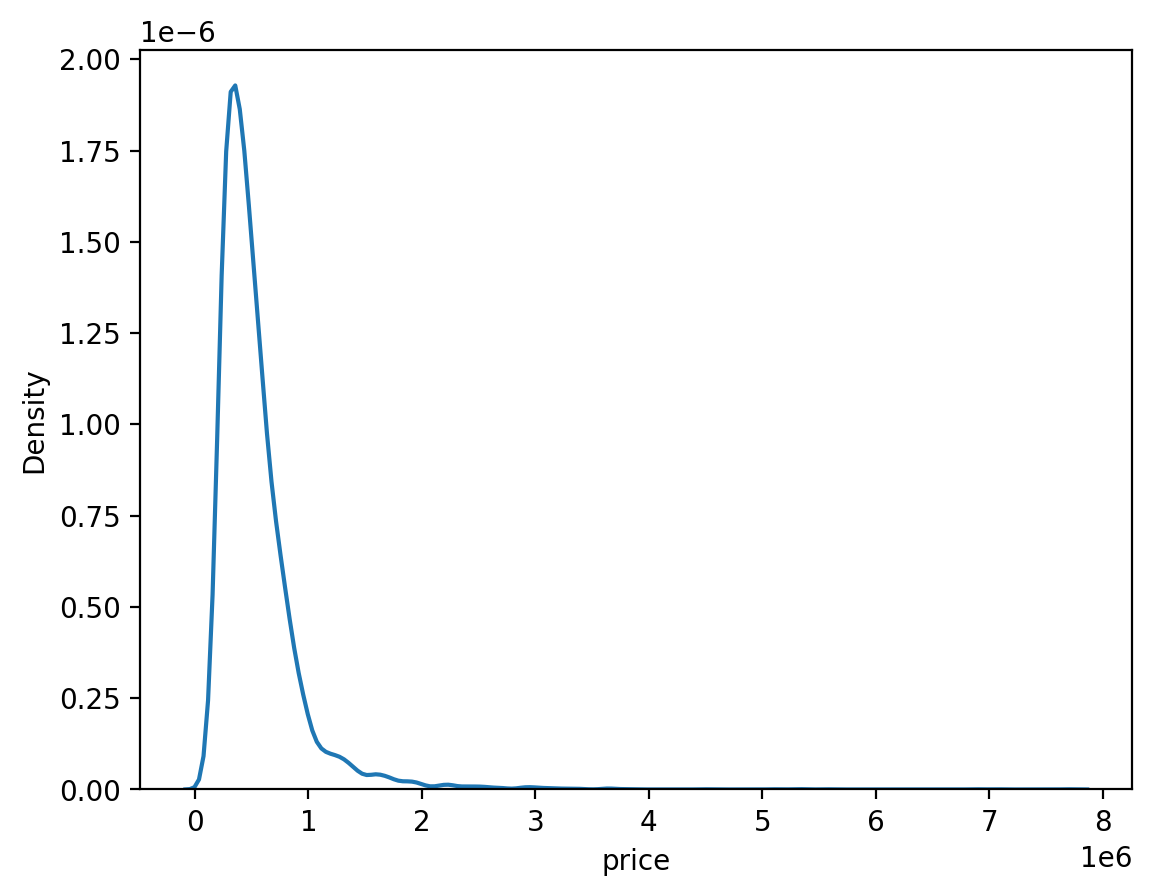

In [194]:
# plot distribution of y
sns.kdeplot(y)
plt.show()

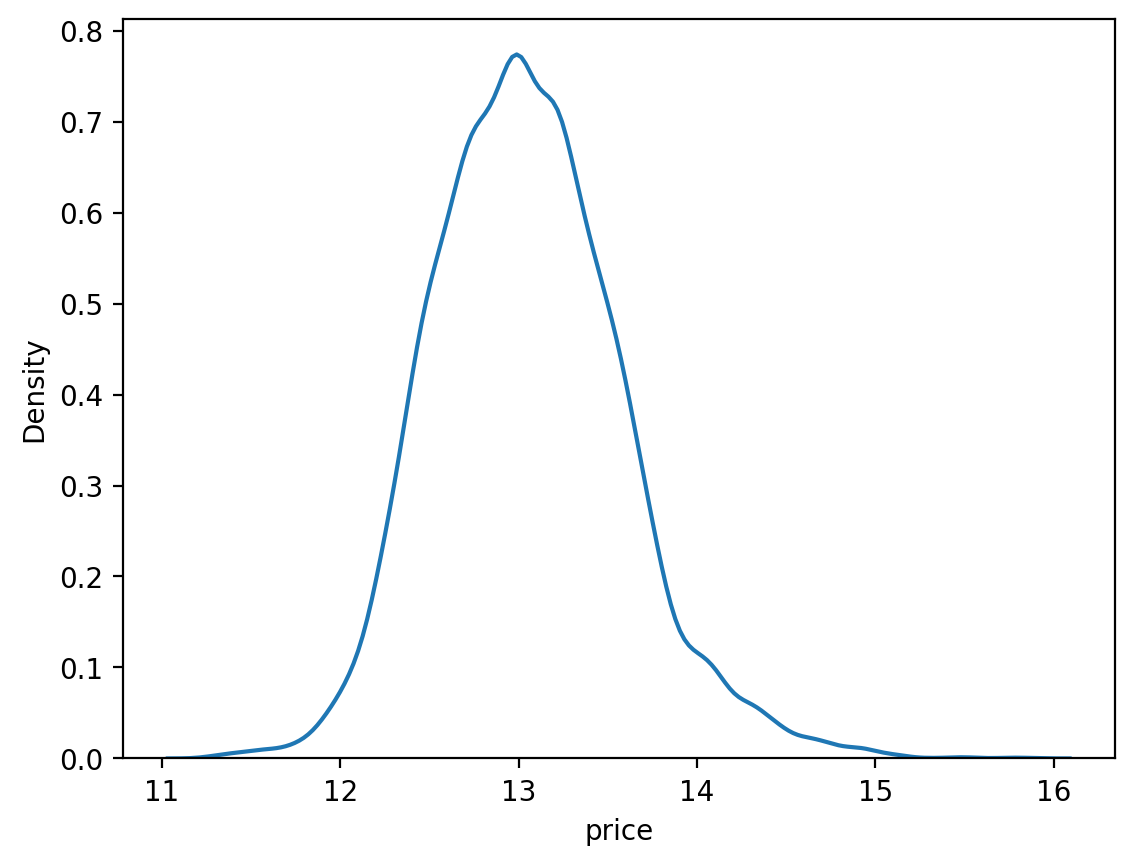

In [195]:
# log transformation of y
y = np.log1p(y)

sns.kdeplot(y)
plt.show()

#### age feature 추가

In [196]:
# effective year column
train['effective_year'] = train[['yr_built', 'yr_renovated']].max(axis=1)
test['effective_year'] = test[['yr_built', 'yr_renovated']].max(axis=1)

# delete yr_built and yr_renovated columns
train.drop(['yr_built', 'yr_renovated'], axis=1, inplace=True)
test.drop(['yr_built', 'yr_renovated'], axis=1, inplace=True)

# add house_age column
train['house_age'] = train['year'] - train['effective_year']
test['house_age'] = test['year'] - test['effective_year']

train.drop(['effective_year'], axis=1, inplace=True)
test.drop(['effective_year'], axis=1, inplace=True)

In [197]:
# convert year feature to categorical feature
label_encoder = LabelEncoder()
train['year'] = label_encoder.fit_transform(train['year'])

# check train set
train.head()

,year,month,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,house_age
0,0,10,3,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.0,98178,47.5112,-122.257,1340,8.639588,59
1,1,2,2,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.0,98028,47.7379,-122.233,2720,8.995041,82
2,1,2,3,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.0,98074,47.6168,-122.045,1800,8.923191,28
3,0,6,3,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.0,98003,47.3097,-122.327,2238,8.827615,19
4,1,1,3,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.0,98198,47.4095,-122.315,1650,9.181118,52


#### 집 위치 관련 feature engineering

zipcode를 범주형 데이터로 변환

In [198]:
unique_zipcodes = set(train['zipcode'])
print(len(unique_zipcodes)) # 70 categories

70


In [199]:
# apply label encoding to zipcode column
label_encoder = LabelEncoder()
train['zipcode'] = label_encoder.fit_transform(train['zipcode'])

lat, long, sqft_living15을 Standardize

In [200]:
from sklearn.preprocessing import StandardScaler

columns_to_normalize = ['lat', 'long', 'sqft_living15']
scaler = StandardScaler()
train[columns_to_normalize] = scaler.fit_transform(train[columns_to_normalize])
print(train[columns_to_normalize].head())

        lat      long  sqft_living15
0 -0.358430 -0.306626      -0.944060
1  1.282425 -0.136763       1.051794
2  0.405903  1.193836      -0.278776
3 -1.816888 -0.802062       0.354691
4 -1.094536 -0.717130      -0.495716


In [201]:
train.head()

,year,month,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,house_age
0,0,10,3,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.0,66,-0.358430,-0.306626,-0.944060,8.639588,59
1,1,2,2,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.0,16,1.282425,-0.136763,1.051794,8.995041,82
2,1,2,3,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.0,37,0.405903,1.193836,-0.278776,8.923191,28
3,0,6,3,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.0,2,-1.816888,-0.802062,0.354691,8.827615,19
4,1,1,3,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.0,68,-1.094536,-0.717130,-0.495716,9.181118,52


## 3. 모델링

In [202]:
gboost = GradientBoostingRegressor(random_state=2025)
xgboost = XGBRegressor(random_state=2025)
lightgbm = LGBMRegressor(random_state=2025, force_col_wise=True)

### Grid Search

In [203]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
    'learning_rate': [0.01, 0.1],
}

In [204]:
grid_search_cv(lightgbm, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[LightGBM] [Info] Total Bins 2278[LightGBM] [Info] Total Bins 2245

[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Total Bins 2280
[LightGBM] [Info] Total Bins 2275
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 19
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 19[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 19[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 19


[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 19
[LightGBM] [Info] Start training from score 13.051670[LightGBM] [Info] Start training from score 13.035255

[LightGBM] [Info] Start training from score 13.052839
[LightGBM] [Info] Start training from score 13.050187
[LightGBM] [Info] Start training from score 13.050660
[LightGBM] [Warning] No further spl

,learning_rate,max_depth,n_estimators,score,RMSLE
7,0.10,10,100,-0.027082,0.164566
6,0.10,10,50,-0.029402,0.171471
5,0.10,1,100,-0.055385,0.235340
4,0.10,1,50,-0.073425,0.270971
3,0.01,10,100,-0.081336,0.285195
2,0.01,10,50,-0.138825,0.372593
1,0.01,1,100,-0.166101,0.407555
0,0.01,1,50,-0.209744,0.457978


In [205]:
grid_search_cv(gboost, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ...learning_rate=0.01, max_depth=1, n_estimators=50; total time=   0.5s
[CV] END ...learning_rate=0.01, max_depth=1, n_estimators=50; total time=   0.5s
[CV] END ...learning_rate=0.01, max_depth=1, n_estimators=50; total time=   0.5s
[CV] END ...learning_rate=0.01, max_depth=1, n_estimators=50; total time=   0.5s
[CV] END ...learning_rate=0.01, max_depth=1, n_estimators=50; total time=   0.5s
[CV] END ..learning_rate=0.01, max_depth=1, n_estimators=100; total time=   0.9s
[CV] END ..learning_rate=0.01, max_depth=1, n_estimators=100; total time=   0.9s
[CV] END ..learning_rate=0.01, max_depth=1, n_estimators=100; total time=   0.9s
[CV] END ..learning_rate=0.01, max_depth=1, n_estimators=100; total time=   0.9s
[CV] END ..learning_rate=0.01, max_depth=1, n_estimators=100; total time=   0.9s
[CV] END ..learning_rate=0.01, max_depth=10, n_estimators=50; total time=   4.0s
[CV] END ..learning_rate=0.01, max_depth=10, n_es

,learning_rate,max_depth,n_estimators,score,RMSLE
7,0.10,10,100,-0.029681,0.172281
6,0.10,10,50,-0.030071,0.173409
5,0.10,1,100,-0.055291,0.235141
3,0.01,10,100,-0.068759,0.262219
4,0.10,1,50,-0.073256,0.270658
2,0.01,10,50,-0.126302,0.355390
1,0.01,1,100,-0.166016,0.407451
0,0.01,1,50,-0.209700,0.457930


In [206]:
grid_search_cv(xgboost, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ...learning_rate=0.01, max_depth=1, n_estimators=50; total time=   0.1s
[CV] END ...learning_rate=0.01, max_depth=1, n_estimators=50; total time=   0.1s
[CV] END ...learning_rate=0.01, max_depth=1, n_estimators=50; total time=   0.1s
[CV] END ...learning_rate=0.01, max_depth=1, n_estimators=50; total time=   0.1s
[CV] END ...learning_rate=0.01, max_depth=1, n_estimators=50; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=1, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=1, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=1, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=1, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=1, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=10, n_estimators=50; total time=   0.8s
[CV] END ..learning_rate=0.01, max_depth=10, n_es

,learning_rate,max_depth,n_estimators,score,RMSLE
7,0.10,10,100,-0.028916,0.170047
6,0.10,10,50,-0.029327,0.171250
5,0.10,1,100,-0.055361,0.235289
3,0.01,10,100,-0.071368,0.267148
4,0.10,1,50,-0.073302,0.270743
2,0.01,10,50,-0.129308,0.359595
1,0.01,1,100,-0.166058,0.407502
0,0.01,1,50,-0.209694,0.457924


### Make Submission

#### Average Blending
여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.

In [207]:
gboost = GradientBoostingRegressor(learning_rate=0.1, max_depth=10, n_estimators=100, random_state=2025)
xgboost = XGBRegressor(learning_rate=0.1, max_depth=10, n_estimators=100, random_state=2025)
lightgbm = LGBMRegressor(learning_rate=0.1, max_depth=10, n_estimators=100, random_state=2025, force_col_wise=True)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

In [208]:
get_cv_score(models, train, y)

Model: GradientBoosting, CV score:0.8930
Model: XGBoost, CV score:0.8958
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 19
[LightGBM] [Info] Start training from score 13.050187
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 2275
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 19
[LightGBM] [Info] Start training from score 13.052839
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 19
[LightGBM] [Info] Start training from score 13.051670
[LightGBM] [Info] Total Bins 2280
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 19
[LightGBM] [Info] Start training from score 13.050660
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 19
[

In [209]:
y_pred = average_blending(models, train, y, test)
print(len(y_pred))
y_pred

[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 19
[LightGBM] [Info] Start training from score 13.048122
6468


array([13.31049273, 13.02609857, 14.49923803, ..., 12.85363253,
       12.78853273, 13.00638939])

In [210]:
result = pd.DataFrame({
    'id' : test_id, 
    'price' : np.expm1(y_pred)
})

result.head()

,id,price
0,15035,6.034938e+05
1,15036,4.541107e+05
2,15037,1.981248e+06
3,15038,4.179822e+05
4,15039,5.174191e+05


In [211]:
submission_path = "~/Desktop/aiffel/AIFFEL_quest_rs/Exploration/Ex02/submission.csv"
result.to_csv(submission_path, index=False)

![Result Screenshot](./results_241186.png)